In [1]:
#import libraries.
import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import keras
from keras import regularizers
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import sounddevice as sd
import tensorflow as tf
from mir_eval import separation 
from pystoi.stoi import stoi 
import h5py
from keras.callbacks import LearningRateScheduler
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
import math
from sklearn.utils import shuffle
from sklearn import preprocessing
import soundfile as sf
import matplotlib.pyplot as plt
from pypesq import pesq

Using TensorFlow backend.


In [2]:
#import libraries.
# import matplotlib.pyplot as plt
# from tabulate import tabulate
import time
import os
import librosa
from librosa.core import stft, istft
import time
import pickle
from keras import backend as K
from tensorflow.keras.models import load_model
# from keras.models import load_model

In [3]:
def reconstruct(wave,angle):
    recon1 = wave*np.cos(angle)+wave*np.sin(angle)*1j
#     recon = np.sqrt(np.power(10, wave))
#     recon1 = recon*np.cos(angle)+recon*np.sin(angle)*1j
    recon = librosa.core.istft((recon1.T), hop_length=128, win_length=512, window='hann')
    return recon

# Loading Model

In [4]:
estimator_A = load_model('Models/Two_stage/512_3/saved-model-adam-046-0.0528.hdf5')
name0 = '512_3_46_SDR'
name1 = '512_3_46_SIR'
name2 = '512_3_46_SAR'
name3 = '512_3_46_STOI'
name4 = '512_3_46_PESQ'

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [5]:
data_series = str(0)

In [6]:
h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_mixed_FFT'  + data_series + '.hdf5','r')
data_shape = h5f['Test_TSP_mixed_FFT' + data_series].shape
print(data_shape)
h5f.close()

(257, 29014)


In [7]:
h5f = h5py.File('TSP/Organized/concatenated/Test_all_len'  + data_series + '.hdf5','r')
all_len = h5f['Test_all_len' + data_series][:]

# Data 

In [8]:
# all
test_point_start0 = 0
test_point_stop0 = data_shape[1]

In [9]:
# FM
FM_test_point_start0 =  0
FM_test_point_stop0 = all_len[36]

In [10]:
# FF
FF_test_point_start0 =  all_len[36]+1
FF_test_point_stop0 = all_len[72]

In [11]:
# MM
MM_test_point_start0 =  all_len[72] + 1
MM_test_point_stop0 = data_shape[1]

In [12]:
indx = [test_point_start0, test_point_stop0, FM_test_point_start0, FM_test_point_stop0, FF_test_point_start0, 
        FF_test_point_stop0, MM_test_point_start0, MM_test_point_stop0]

In [13]:
fft_samples = 257
sr = 16000

# calc of sdr, sir, sar and stoi

In [14]:
all_sdr = {}
all_sir = {}
all_sar = {}
all_stoi = {}

for i in range(0,len(indx),2):
    test_point_start0 = indx[i]
    test_point_stop0 = indx[i+1]
    h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_mixed_FFT'  + data_series + '.hdf5','r')
    test_input = h5f['Test_TSP_mixed_FFT' + data_series][:, test_point_start0 : test_point_stop0]
    h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_clean_FFTs'  + data_series + '.hdf5','r')
    test_target = h5f['Test_TSP_clean_FFTs' + data_series][:, test_point_start0 : test_point_stop0]
    h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_mixed_phase'  + data_series + '.hdf5','r')
    mixed_phase = h5f['Test_TSP_mixed_phase' + data_series][:, test_point_start0 : test_point_stop0]
    h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_clean_phases'  + data_series + '.hdf5','r')
    clean_phase = h5f['Test_TSP_clean_phases' + data_series][:, test_point_start0 : test_point_stop0]
    norms = np.zeros(test_input.shape[1])
    for j in range(test_input.shape[1]):
        norms[j] = np.linalg.norm(test_input[:,j])
    test_input = preprocessing.normalize(test_input, norm='l2', axis=0, copy=True)
    prediction = estimator_A.predict(test_input.T)
    test_input = np.multiply(test_input,norms)
    prediction0 = np.multiply(test_input.T, prediction[:,0:fft_samples])
    prediction1 = np.multiply(test_input.T, prediction[:,fft_samples:])
    speaker1 = reconstruct(prediction0, mixed_phase.T)
    speaker2 = reconstruct(prediction1, mixed_phase.T)
    clean_recon1 = reconstruct(test_target[0:fft_samples,:].T, clean_phase[0:fft_samples,:].T)
    clean_recon2 = reconstruct(test_target[fft_samples:,:].T, clean_phase[fft_samples:,:].T)
    mixed_recon = reconstruct(test_input.T, mixed_phase.T)
    
    st_recon1 = stoi(speaker1, clean_recon1, sr, extended=False)
    st_recon2 = stoi(speaker2, clean_recon2, sr, extended=False)
    st_mixed1 = stoi(mixed_recon, clean_recon1, sr, extended=False)
    st_mixed2 = stoi(mixed_recon, clean_recon2, sr, extended=False)
    
    sdr_recon1, sir_recon1, sar_recon1, perm_recon1 = separation.bss_eval_sources(speaker1, clean_recon1, compute_permutation=True)
    sdr_recon2, sir_recon2, sar_recon2, perm_recon2 = separation.bss_eval_sources(speaker2, clean_recon2, compute_permutation=True)
    sdr_mixed1, sir_mixed1, sar_mixed1, perm_mixed1 = separation.bss_eval_sources(mixed_recon, clean_recon1, compute_permutation=True)
    sdr_mixed2, sir_mixed2, sar_mixed2, perm_mixed2 = separation.bss_eval_sources(mixed_recon, clean_recon2, compute_permutation=True)
    
    temp_sdr = [sdr_mixed1, sdr_recon1, sdr_mixed2, sdr_recon2]
    temp_sir = [sir_mixed1, sir_recon1, sir_mixed2, sir_recon2]
    temp_sar = [sar_mixed1, sar_recon1, sar_mixed2, sar_recon2]
    temp_stoi = [st_mixed1, st_recon1,  st_mixed2, st_recon2]
    
    all_sdr[str(i/2)] = temp_sdr
    all_sir[str(i/2)] = temp_sir
    all_sar[str(i/2)] = temp_sar
    all_stoi[str(i/2)] = temp_stoi


In [15]:
all_sdr

{'0.0': [array([1.00892557]),
  array([5.48872295]),
  array([0.17736761]),
  array([4.90327238])],
 '1.0': [array([4.91488976]),
  array([8.07420325]),
  array([-3.37590487]),
  array([2.26469528])],
 '2.0': [array([-0.36496601]),
  array([4.48144638]),
  array([2.47553754]),
  array([6.60984801])],
 '3.0': [array([0.87810111]),
  array([3.4230308]),
  array([-0.01533344]),
  array([2.63370361])]}

# Calc of PESQ

In [25]:
all_pesq = {}
for i in range(0,len(indx),2):
    pesq_recon1 = []
    pesq_recon2 = []
    pesq_mixed1 = []
    pesq_mixed2 = []
    test_point_start0 = indx[i]
    test_point_stop0 = indx[i+1]
    pesq_indx = np.arange(test_point_start0,test_point_stop0,500)
    pesq_indx = np.append(pesq_indx,test_point_stop0)
    for j in range(len(pesq_indx)-1):
        h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_mixed_FFT'  + data_series + '.hdf5','r')
        test_input = h5f['Test_TSP_mixed_FFT' + data_series][:, pesq_indx[j]: pesq_indx[j+1]]
        h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_clean_FFTs'  + data_series + '.hdf5','r')
        test_target = h5f['Test_TSP_clean_FFTs' + data_series][:, pesq_indx[j]: pesq_indx[j+1]]
        h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_mixed_phase'  + data_series + '.hdf5','r')
        mixed_phase = h5f['Test_TSP_mixed_phase' + data_series][:, pesq_indx[j]: pesq_indx[j+1]]
        h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_clean_phases'  + data_series + '.hdf5','r')
        clean_phase = h5f['Test_TSP_clean_phases' + data_series][:, pesq_indx[j]: pesq_indx[j+1]]
        norms = np.zeros(test_input.shape[1])
        for j in range(test_input.shape[1]):
            norms[j] = np.linalg.norm(test_input[:,j])
        test_input_normalized = preprocessing.normalize(test_input, norm='l2', axis=0, copy=True)
        prediction = estimator_A.predict(test_input_normalized.T)
    #     test_input = np.multiply(test_input,norms)
        prediction0 = np.multiply(test_input.T, prediction[:,0:fft_samples])
        prediction1 = np.multiply(test_input.T, prediction[:,fft_samples:])
        speaker1 = reconstruct(prediction0, mixed_phase.T)
        speaker2 = reconstruct(prediction1, mixed_phase.T)
        clean_recon1 = reconstruct(test_target[0:fft_samples,:].T, clean_phase[0:fft_samples,:].T)
        clean_recon2 = reconstruct(test_target[fft_samples:,:].T, clean_phase[fft_samples:,:].T)
        mixed_recon = reconstruct(test_input.T, mixed_phase.T)

        pesq_recon1.append(pesq(clean_recon1, speaker1, sr))
        pesq_recon2.append(pesq(clean_recon2, speaker2, sr))
        pesq_mixed1.append(pesq(clean_recon1, mixed_recon, sr))
        pesq_mixed2.append(pesq(clean_recon2, mixed_recon, sr))
    
    temp_pesq = [np.mean(pesq_mixed1), np.mean(pesq_recon1),  np.mean(pesq_mixed2), np.mean(pesq_recon2)]

    all_pesq[str(i/2)] = temp_pesq

In [20]:

all_pesq = {}
for i in range(0,len(indx),2):
    test_point_start0 = indx[i]
    test_point_stop0 = indx[i+1]
    pesq_indx = np.arange(test_point_start0,test_point_stop0,500)
    pesq_indx = np.append(pesq_indx,test_point_stop0)
    print(test_point_start0)
    print(test_point_stop0)
    print(pesq_indx)
    print(type(pesq_indx))
    h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_mixed_FFT'  + data_series + '.hdf5','r')
    test_input = h5f['Test_TSP_mixed_FFT' + data_series][:, test_point_start0 : test_point_stop0]
    h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_clean_FFTs'  + data_series + '.hdf5','r')
    test_target = h5f['Test_TSP_clean_FFTs' + data_series][:, test_point_start0 : test_point_stop0]
    h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_mixed_phase'  + data_series + '.hdf5','r')
    mixed_phase = h5f['Test_TSP_mixed_phase' + data_series][:, test_point_start0 : test_point_stop0]
    h5f = h5py.File('TSP/Organized/concatenated/Test_TSP_clean_phases'  + data_series + '.hdf5','r')
    clean_phase = h5f['Test_TSP_clean_phases' + data_series][:, test_point_start0 : test_point_stop0]
    norms = np.zeros(test_input.shape[1])
    for j in range(test_input.shape[1]):
        norms[j] = np.linalg.norm(test_input[:,j])
    test_input_normalized = preprocessing.normalize(test_input, norm='l2', axis=0, copy=True)
    prediction = estimator_A.predict(test_input_normalized.T)
#     test_input = np.multiply(test_input,norms)
    prediction0 = np.multiply(test_input.T, prediction[:,0:fft_samples])
    prediction1 = np.multiply(test_input.T, prediction[:,fft_samples:])
    speaker1 = reconstruct(prediction0, mixed_phase.T)
    speaker2 = reconstruct(prediction1, mixed_phase.T)
    clean_recon1 = reconstruct(test_target[0:fft_samples,:].T, clean_phase[0:fft_samples,:].T)
    clean_recon2 = reconstruct(test_target[fft_samples:,:].T, clean_phase[fft_samples:,:].T)
    mixed_recon = reconstruct(test_input.T, mixed_phase.T)
    
    pesq_recon1 = pesq(clean_recon1, speaker1, sr)
    pesq_recon2 = pesq(clean_recon2, speaker2, sr)
    pesq_mixed1 = pesq(clean_recon1, mixed_recon, sr)
    pesq_mixed2 = pesq(clean_recon2, mixed_recon, sr)

    temp_pesq = [pesq_mixed1, pesq_recon1,  pesq_mixed2, pesq_recon2]

    all_pesq[str(i/2)] = temp_pesq

0
29014
[    0   500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500
  6000  6500  7000  7500  8000  8500  9000  9500 10000 10500 11000 11500
 12000 12500 13000 13500 14000 14500 15000 15500 16000 16500 17000 17500
 18000 18500 19000 19500 20000 20500 21000 21500 22000 22500 23000 23500
 24000 24500 25000 25500 26000 26500 27000 27500 28000 28500 29000 29014]
<class 'numpy.ndarray'>
0
9449
[   0  500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500
 7000 7500 8000 8500 9000 9449]
<class 'numpy.ndarray'>
9450
19184
[ 9450  9950 10450 10950 11450 11950 12450 12950 13450 13950 14450 14950
 15450 15950 16450 16950 17450 17950 18450 18950 19184]
<class 'numpy.ndarray'>
19185
29014
[19185 19685 20185 20685 21185 21685 22185 22685 23185 23685 24185 24685
 25185 25685 26185 26685 27185 27685 28185 28685 29014]
<class 'numpy.ndarray'>


# SDR Plot

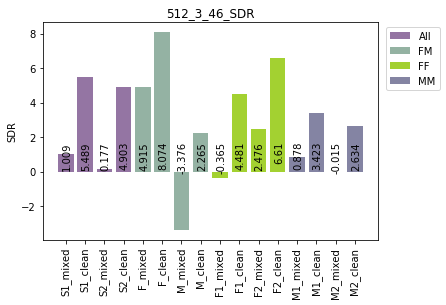

In [16]:

barWidth = 2

bars0 = ('S1_mixed','S1_clean', 'S2_mixed', 'S2_clean')
bars1 = ('F_mixed','F_clean', 'M_mixed', 'M_clean')
bars2 = ('F1_mixed','F1_clean', 'F2_mixed', 'F2_clean')
bars3 = ('M1_mixed','M1_clean', 'M2_mixed', 'M2_clean')

x_pos0 = np.arange(len(bars0)) + barWidth
x_pos1 = np.arange(len(bars1)) + len(bars0) + barWidth
x_pos2 = np.arange(len(bars2)) + len(bars0) + len(bars1) + barWidth
x_pos3 = np.arange(len(bars3)) + len(bars0) + len(bars1) + len(bars2) + barWidth
x_pos = list(x_pos0) + list(x_pos1) + list(x_pos2) + list(x_pos3)

 
# Create bars
plt.bar(x_pos0, np.squeeze(all_sdr['0.0']),color = (0.3,0.1,0.4,0.6), label='All')
plt.bar(x_pos1, np.squeeze(all_sdr['1.0']),color = (0.3,0.5,0.4,0.6), label='FM')
plt.bar(x_pos2, np.squeeze(all_sdr['2.0']),color = (0.6,0.8,0.1,0.9), label='FF')
plt.bar(x_pos3, np.squeeze(all_sdr['3.0']),color = (0.2,0.2,0.4,0.6), label='MM')

# Create legend
plt.legend(bbox_to_anchor=(1.2, 1),loc=1)

# write the values
values =  list(np.round(np.squeeze(all_sdr['0.0']),3)) + list(np.round(np.squeeze(all_sdr['1.0']),3)) + list(np.round(np.squeeze(all_sdr['2.0']),3)) + list(np.round(np.squeeze(all_sdr['3.0']),3))
for i, v in enumerate(values):
    plt.text(i + barWidth - 0.2, 1.3 , str(v), color='black', fontsize=10, rotation=90)

# lables
plt.title(name0)
# ax.t_xlabel()
plt.ylabel('SDR')
# Create names on the x-axis
plt.xticks([r + barWidth for r in range(len(x_pos))], 
           ['S1_mixed','S1_clean', 'S2_mixed', 'S2_clean',
            'F_mixed','F_clean', 'M_mixed', 'M_clean',
            'F1_mixed','F1_clean', 'F2_mixed', 'F2_clean',
            'M1_mixed','M1_clean', 'M2_mixed', 'M2_clean'
            ], rotation=90)
fig1 = plt.gcf()
plt.show()
fig1.savefig('figures/' + name0 + '.png', dpi=300 , bbox_inches='tight')



# SIR Plot

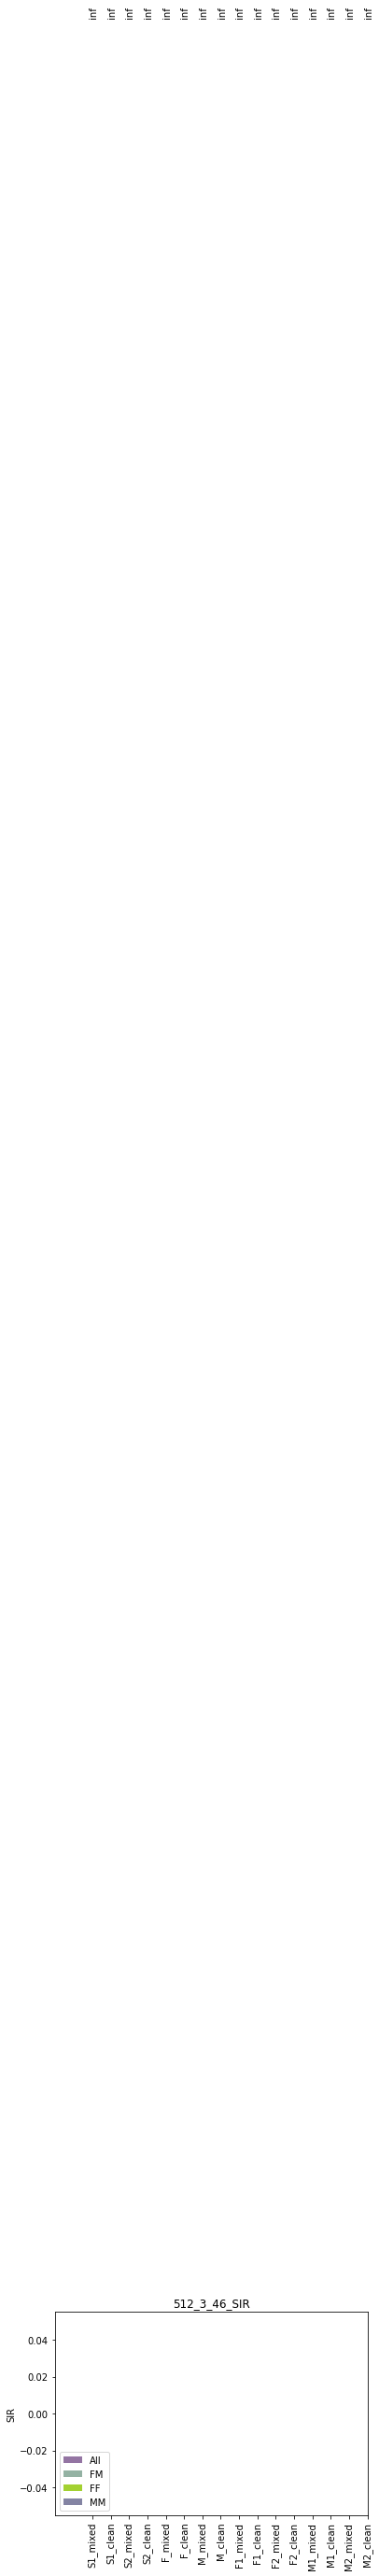

In [21]:

barWidth = 2

bars0 = ('S1_mixed','S1_clean', 'S2_mixed', 'S2_clean')
bars1 = ('F_mixed','F_clean', 'M_mixed', 'M_clean')
bars2 = ('F1_mixed','F1_clean', 'F2_mixed', 'F2_clean')
bars3 = ('M1_mixed','M1_clean', 'M2_mixed', 'M2_clean')

x_pos0 = np.arange(len(bars0)) + barWidth
x_pos1 = np.arange(len(bars1)) + len(bars0) + barWidth
x_pos2 = np.arange(len(bars2)) + len(bars0) + len(bars1) + barWidth
x_pos3 = np.arange(len(bars3)) + len(bars0) + len(bars1) + len(bars2) + barWidth
x_pos = list(x_pos0) + list(x_pos1) + list(x_pos2) + list(x_pos3)

 
# Create bars
plt.bar(x_pos0, np.squeeze(all_sir['0.0']),color = (0.3,0.1,0.4,0.6), label='All')
plt.bar(x_pos1, np.squeeze(all_sir['1.0']),color = (0.3,0.5,0.4,0.6), label='FM')
plt.bar(x_pos2, np.squeeze(all_sir['2.0']),color = (0.6,0.8,0.1,0.9), label='FF')
plt.bar(x_pos3, np.squeeze(all_sir['3.0']),color = (0.2,0.2,0.4,0.6), label='MM')

# Create legend
plt.legend(bbox_to_anchor=(1.2, 1),loc=1)

# write the values
values =  list(np.round(np.squeeze(all_sir['0.0']),3)) + list(np.round(np.squeeze(all_sir['1.0']),3)) + list(np.round(np.squeeze(all_sir['2.0']),3)) + list(np.round(np.squeeze(all_sir['3.0']),3))
for i, v in enumerate(values):
    plt.text(i + barWidth - 0.2, 1.3 , str(v), color='black', fontsize=10, rotation=90)

# lables
plt.title(name1)
# ax.t_xlabel()
plt.ylabel('SIR')
# Create names on the x-axis
plt.xticks([r + barWidth for r in range(len(x_pos))], 
           ['S1_mixed','S1_clean', 'S2_mixed', 'S2_clean',
            'F_mixed','F_clean', 'M_mixed', 'M_clean',
            'F1_mixed','F1_clean', 'F2_mixed', 'F2_clean',
            'M1_mixed','M1_clean', 'M2_mixed', 'M2_clean'
            ], rotation=90)
fig1 = plt.gcf()
plt.show()
fig1.savefig('figures/' + name1 + '.png', dpi=300 , bbox_inches='tight')



# SAR Plot

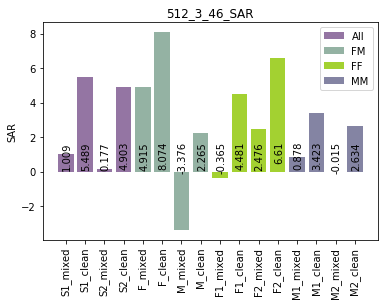

In [22]:

barWidth = 2

bars0 = ('S1_mixed','S1_clean', 'S2_mixed', 'S2_clean')
bars1 = ('F_mixed','F_clean', 'M_mixed', 'M_clean')
bars2 = ('F1_mixed','F1_clean', 'F2_mixed', 'F2_clean')
bars3 = ('M1_mixed','M1_clean', 'M2_mixed', 'M2_clean')

x_pos0 = np.arange(len(bars0)) + barWidth
x_pos1 = np.arange(len(bars1)) + len(bars0) + barWidth
x_pos2 = np.arange(len(bars2)) + len(bars0) + len(bars1) + barWidth
x_pos3 = np.arange(len(bars3)) + len(bars0) + len(bars1) + len(bars2) + barWidth
x_pos = list(x_pos0) + list(x_pos1) + list(x_pos2) + list(x_pos3)

 
# Create bars
plt.bar(x_pos0, np.squeeze(all_sar['0.0']),color = (0.3,0.1,0.4,0.6), label='All')
plt.bar(x_pos1, np.squeeze(all_sar['1.0']),color = (0.3,0.5,0.4,0.6), label='FM')
plt.bar(x_pos2, np.squeeze(all_sar['2.0']),color = (0.6,0.8,0.1,0.9), label='FF')
plt.bar(x_pos3, np.squeeze(all_sar['3.0']),color = (0.2,0.2,0.4,0.6), label='MM')

# Create legend
plt.legend(bbox_to_anchor=(1.2, 1),loc=1)

# write the values
values =  list(np.round(np.squeeze(all_sar['0.0']),3)) + list(np.round(np.squeeze(all_sar['1.0']),3)) + list(np.round(np.squeeze(all_sar['2.0']),3)) + list(np.round(np.squeeze(all_sar['3.0']),3))
for i, v in enumerate(values):
    plt.text(i + barWidth - 0.2, 1.3 , str(v), color='black', fontsize=10, rotation=90)

# lables
plt.title(name2)
# ax.t_xlabel()
plt.ylabel('SAR')
# Create names on the x-axis
plt.xticks([r + barWidth for r in range(len(x_pos))], 
           ['S1_mixed','S1_clean', 'S2_mixed', 'S2_clean',
            'F_mixed','F_clean', 'M_mixed', 'M_clean',
            'F1_mixed','F1_clean', 'F2_mixed', 'F2_clean',
            'M1_mixed','M1_clean', 'M2_mixed', 'M2_clean'
            ], rotation=90)
fig1 = plt.gcf()
plt.show()
fig1.savefig('figures/' + name2 + '.png', dpi=300 , bbox_inches='tight')



# STOI Plot

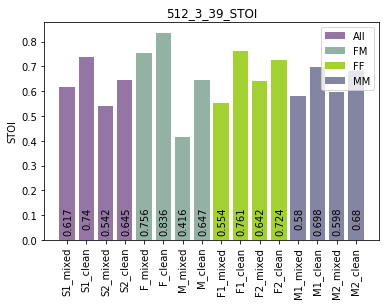

In [74]:

barWidth = 2

bars0 = ('S1_mixed','S1_clean', 'S2_mixed', 'S2_clean')
bars1 = ('F_mixed','F_clean', 'M_mixed', 'M_clean')
bars2 = ('F1_mixed','F1_clean', 'F2_mixed', 'F2_clean')
bars3 = ('M1_mixed','M1_clean', 'M2_mixed', 'M2_clean')

x_pos0 = np.arange(len(bars0)) + barWidth
x_pos1 = np.arange(len(bars1)) + len(bars0) + barWidth
x_pos2 = np.arange(len(bars2)) + len(bars0) + len(bars1) + barWidth
x_pos3 = np.arange(len(bars3)) + len(bars0) + len(bars1) + len(bars2) + barWidth
x_pos = list(x_pos0) + list(x_pos1) + list(x_pos2) + list(x_pos3)

 
# Create bars
plt.bar(x_pos0, np.squeeze(all_stoi['0.0']),color = (0.3,0.1,0.4,0.6), label='All')
plt.bar(x_pos1, np.squeeze(all_stoi['1.0']),color = (0.3,0.5,0.4,0.6), label='FM')
plt.bar(x_pos2, np.squeeze(all_stoi['2.0']),color = (0.6,0.8,0.1,0.9), label='FF')
plt.bar(x_pos3, np.squeeze(all_stoi['3.0']),color = (0.2,0.2,0.4,0.6), label='MM')

# Create legend
plt.legend(bbox_to_anchor=(1.2, 1),loc=1)

# write the values
values =  list(np.round(np.squeeze(all_stoi['0.0']),3)) + list(np.round(np.squeeze(all_stoi['1.0']),3)) + list(np.round(np.squeeze(all_stoi['2.0']),3)) + list(np.round(np.squeeze(all_stoi['3.0']),3))
for i, v in enumerate(values):
    plt.text(i + barWidth - 0.2, 0.1 , str(v), color='black', fontsize=10, rotation=90)

# lables
plt.title(name3)
# ax.t_xlabel()
plt.ylabel('STOI')
# Create names on the x-axis
plt.xticks([r + barWidth for r in range(len(x_pos))], 
           ['S1_mixed','S1_clean', 'S2_mixed', 'S2_clean',
            'F_mixed','F_clean', 'M_mixed', 'M_clean',
            'F1_mixed','F1_clean', 'F2_mixed', 'F2_clean',
            'M1_mixed','M1_clean', 'M2_mixed', 'M2_clean'
            ], rotation=90)
fig2 = plt.gcf()
plt.show()
fig2.savefig('figures/' + name3 + '.png', dpi=300 , bbox_inches='tight')



# PESQ Plot

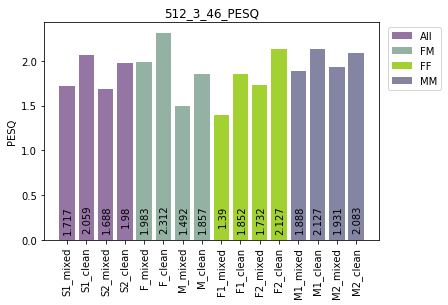

In [42]:

barWidth = 2

bars0 = ('S1_mixed','S1_clean', 'S2_mixed', 'S2_clean')
bars1 = ('F_mixed','F_clean', 'M_mixed', 'M_clean')
bars2 = ('F1_mixed','F1_clean', 'F2_mixed', 'F2_clean')
bars3 = ('M1_mixed','M1_clean', 'M2_mixed', 'M2_clean')

x_pos0 = np.arange(len(bars0)) + barWidth
x_pos1 = np.arange(len(bars1)) + len(bars0) + barWidth
x_pos2 = np.arange(len(bars2)) + len(bars0) + len(bars1) + barWidth
x_pos3 = np.arange(len(bars3)) + len(bars0) + len(bars1) + len(bars2) + barWidth
x_pos = list(x_pos0) + list(x_pos1) + list(x_pos2) + list(x_pos3)

 
# Create bars
plt.bar(x_pos0, np.squeeze(all_pesq['0.0']),color = (0.3,0.1,0.4,0.6), label='All')
plt.bar(x_pos1, np.squeeze(all_pesq['1.0']),color = (0.3,0.5,0.4,0.6), label='FM')
plt.bar(x_pos2, np.squeeze(all_pesq['2.0']),color = (0.6,0.8,0.1,0.9), label='FF')
plt.bar(x_pos3, np.squeeze(all_pesq['3.0']),color = (0.2,0.2,0.4,0.6), label='MM')

# Create legend
plt.legend(bbox_to_anchor=(1.2, 1),loc=1)

# write the values
values =  list(np.round(np.squeeze(all_pesq['0.0']),3)) + list(np.round(np.squeeze(all_pesq['1.0']),3)) + list(np.round(np.squeeze(all_pesq['2.0']),3)) + list(np.round(np.squeeze(all_pesq['3.0']),3))
for i, v in enumerate(values):
    plt.text(i + barWidth - 0.2, 0.3 , str(v), color='black', fontsize=10, rotation=90)

# lables
plt.title(name4)
# ax.t_xlabel()
plt.ylabel('PESQ')
# Create names on the x-axis
plt.xticks([r + barWidth for r in range(len(x_pos))], 
           ['S1_mixed','S1_clean', 'S2_mixed', 'S2_clean',
            'F_mixed','F_clean', 'M_mixed', 'M_clean',
            'F1_mixed','F1_clean', 'F2_mixed', 'F2_clean',
            'M1_mixed','M1_clean', 'M2_mixed', 'M2_clean'
            ], rotation=90)
fig2 = plt.gcf()
plt.show()
fig2.savefig('figures/' + name4 + '.png', dpi=300 , bbox_inches='tight')



In [25]:
print('STOI_recon1=', st_recon1)
print('STOI_recon2=', st_recon2)
print('STOI_mixed1=', st_mixed1)
print('STOI_mixed2=', st_mixed2)

STOI_recon1= 0.7484800260927625
STOI_recon2= 0.6617332535895908
STOI_mixed1= 0.6283168544837595
STOI_mixed2= 0.5435481313152923


In [26]:
sdr_recon1, sir_recon1, sar_recon1, perm_recon1 = separation.bss_eval_sources(speaker1, clean_recon1, compute_permutation=True)
sdr_recon2, sir_recon2, sar_recon2, perm_recon2 = separation.bss_eval_sources(speaker2, clean_recon2, compute_permutation=True)

In [27]:
sdr_mixed1, sir_mixed1, sar_mixed1, perm_mixed1 = separation.bss_eval_sources(mixed_recon, clean_recon1, compute_permutation=True)
sdr_mixed2, sir_mixed2, sar_mixed2, perm_mixed2 = separation.bss_eval_sources(mixed_recon, clean_recon2, compute_permutation=True)

In [28]:
print('SDR_recon1=', sdr_recon1)
print('SDR_recon2=', sdr_recon2)
print('SDR_mixed1=', sdr_mixed1)
print('SDR_mixed2=', sdr_mixed2)

SDR_recon1= [5.61239878]
SDR_recon2= [4.72275549]
SDR_mixed1= [1.36286961]
SDR_mixed2= [-0.16238854]


In [249]:
print('SIR_recon1=', sir_recon1)
print('SIR_recon2=', sir_recon2)
print('SIR_mixed1=', sir_mixed1)
print('SIR_mixed2=', sir_mixed2)

SIR_recon1= [inf]
SIR_recon2= [inf]
SIR_mixed1= [inf]
SIR_mixed2= [inf]


In [50]:
sd.play(speaker1[0:125632], sr)

In [55]:
sd.play(speaker2[0:125632], sr)

In [227]:
sd.play(clean_recon1[0:125632], sr)

In [56]:
sd.play(clean_recon2[0:125632], sr)

In [54]:
sd.play(mixed_recon[0:125632], sr)

In [51]:
mixed_recon.shape

(1256320,)

In [376]:
sf.write('TSP/Predicted/speaker1_FM.wav', speaker1, 48000)
sf.write('TSP/Predicted/speaker2_FM.wav', speaker2, 48000)
sf.write('TSP/Predicted/clean1_FM.wav', clean_recon1, 48000)
sf.write('TSP/Predicted/clean2_FM.wav', clean_recon2, 48000)
sf.write('TSP/Predicted/mixed_FM.wav', mixed_recon, 48000)

In [397]:
sf.write('TSP/Predicted/speaker1_FF.wav', speaker1, 48000)
sf.write('TSP/Predicted/speaker2_FF.wav', speaker2, 48000)
sf.write('TSP/Predicted/clean1_FF.wav', clean_recon1, 48000)
sf.write('TSP/Predicted/clean2_FF.wav', clean_recon2, 48000)
sf.write('TSP/Predicted/mixed_FF.wav', mixed_recon, 48000)

In [413]:
sf.write('TSP/Predicted/speaker1_MM.wav', speaker1, 48000)
sf.write('TSP/Predicted/speaker2_MM.wav', speaker2, 48000)
sf.write('TSP/Predicted/clean1_MM.wav', clean_recon1, 48000)
sf.write('TSP/Predicted/clean2_MM.wav', clean_recon2, 48000)
sf.write('TSP/Predicted/mixed_MM.wav', mixed_recon, 48000)

In [30]:
from pypesq import pesq
score = pesq(clean_recon1, speaker1, 48000)
print(score)

ValueError: sample rate must be 16000 or 8000

In [98]:
def loss_DNNC(y_true = test_target.T, y_pred = test_target.T, Lambda = 0.05):
    loss = K.sum(K.square(y_true - y_pred)) 
    - Lambda * K.sum(K.square(y_true[0:257,:] - y_pred[0:257,:]) + K.square(y_true[257:,:] - y_pred[257:,:]))
    return loss

In [99]:
estimator_C = load_model('Models/Two_stage/Model_C0.h5', 
                          custom_objects={'loss_DNNC': loss_DNNC})

In [100]:
sec_set = np.concatenate((speaker1 , speaker2), axis=1)

In [101]:
sec_set = preprocessing.normalize(sec_set, norm='l2', axis=1, copy=True)
test_target = preprocessing.normalize(test_target, norm='l2', axis=1, copy=True)

In [102]:
prediction2 = estimator_C.predict(sec_set)

In [103]:
prediction2.shape

(18634, 514)

In [104]:
s1_C = reconstruct(prediction2[:,0:257], angle_mixed)
s2_C = reconstruct(prediction2[:,257:], angle_mixed)

In [105]:
clean_recon1 = reconstruct(test_target[:,0:fft_samples], angle_clean[:,0:fft_samples])
clean_recon2 = reconstruct(test_target[:,fft_samples:], angle_clean[:,fft_samples:])

In [106]:
st_recon1 = stoi(s1_C, clean_recon1, 16000, extended=False)
st_recon2 = stoi(s2_C, clean_recon2, 16000, extended=False)

In [107]:
sdr_recon1, sir_recon1, sar_recon1, perm_recon1 = separation.bss_eval_sources(s1_C, clean_recon1, compute_permutation=True)
sdr_recon2, sir_recon2, sar_recon2, perm_recon2 = separation.bss_eval_sources(s2_C, clean_recon2, compute_permutation=True)

In [108]:
print('SDR_recon1=', sdr_recon1)
print('SDR_recon2=', sdr_recon2)
print('SDR_mixed=', sdr_mixed)

SDR_recon1= [-4.51841408]
SDR_recon2= [-2.20552222]
SDR_mixed= [-4.78920035]


In [109]:
print('STOI_recon1=', st_recon1)
print('STOI_recon2=', st_recon2)
print('STOI_mixed=', st_mixed)

STOI_recon1= 0.2992286684160478
STOI_recon2= 0.36715637272317214
STOI_mixed= 0.3243004405902902


In [50]:
sd.play(s1_C[start:stop]*2000, 16000)